<a href="https://colab.research.google.com/github/writezubair-cpu/ZAK-TEST_AI_Training/blob/main/Copy_of_energy_plant_visual_ai_clip_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Energy Plant Visual AI Demo – CLIP on Hugging Face

In this project, we extend the **energy plant** use case into **Visual AI** using an open‑source model from Hugging Face.

We will:
- Use the **OpenAI CLIP** vision–language model (via Hugging Face: `openai/clip-vit-base-patch32`)  
- Take a **photo of an energy plant component** (e.g., turbine, valve, control panel, switchgear)  
- Ask the model to **classify what the picture is about** using zero‑shot learning  
- Build a small **labelling pipeline** that can be used for:
  - Quickly tagging plant images (component type, area, risk category)  
  - Preparing data for supervised training later  
  - Demonstrating Visual AI in an MLOps / monitoring context

> 💡 **Workshop goal:**  
> Show students how they can go from **raw images** → **pre‑trained open‑source model** → **meaningful labels** without training a deep network from scratch.


In [ ]:
# 1. Install dependencies (run this once in Colab or your environment)
# If you're running locally and already have these installed, you can skip this cell.

!pip install -q transformers==4.46.0 torch pillow matplotlib pandas

In [ ]:
# 2. Imports and configuration

import os
from typing import List

import torch
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

from transformers import CLIPProcessor, CLIPModel

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Load CLIP model & processor from Hugging Face
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

print("Model loaded:", model_name)

Using device: cpu
Model loaded: openai/clip-vit-base-patch32


## 3. Understanding CLIP in Simple Terms

**CLIP** (Contrastive Language–Image Pre‑training) is a model that:

- Takes an **image** and a set of **text prompts** (e.g., *"a photo of a turbine"*, *"a photo of a control panel"*).  
- Embeds both into a shared space and computes **similarity scores**.  
- The text whose embedding is closest to the image is considered the **best label**.

We will use CLIP in a **zero‑shot** way:

- No extra training on our side.  
- We only define **good, descriptive prompts** for the different plant components / conditions we care about.  


In [ ]:
# 4. Define candidate labels for the energy plant

# Plain labels (for logging / readability)
plain_labels = [
    "turbine",
    "control room",
    "control panel",
    "switchgear",
    "valve",
    "pipeline",
    "cooling tower",
    "boiler area",
    "pump",
    "electrical cabinet",
]

# Text prompts for CLIP – more descriptive usually works better
text_prompts = [f"a photo of a {lbl} in an industrial energy plant" for lbl in plain_labels]

for p in text_prompts:
    print(p)

a photo of a turbine in an industrial energy plant
a photo of a control room in an industrial energy plant
a photo of a control panel in an industrial energy plant
a photo of a switchgear in an industrial energy plant
a photo of a valve in an industrial energy plant
a photo of a pipeline in an industrial energy plant
a photo of a cooling tower in an industrial energy plant
a photo of a boiler area in an industrial energy plant
a photo of a pump in an industrial energy plant
a photo of a electrical cabinet in an industrial energy plant


In [ ]:
# 5. Helper functions: load image, classify, and visualize

def load_image(image_path: str) -> Image.Image:
    """Load an image from a local path."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = Image.open(image_path).convert("RGB")
    return img


def classify_image_with_clip(
    image: Image.Image,
    text_prompts: List[str],
    model: CLIPModel,
    processor: CLIPProcessor,
    device: str = "cpu",
    top_k: int = 5,
):
    """Run CLIP on a single image + list of text prompts and return top-k scores."""

    # Prepare inputs
    inputs = processor(
        text=text_prompts,
        images=image,
        return_tensors="pt",
        padding=True
    ).to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        # CLIP returns logits_per_image: [batch_size, num_text_prompts]
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=-1).cpu().numpy().flatten()

    # Sort prompts by probability
    indices = probs.argsort()[::-1]  # descending
    top_indices = indices[:top_k]

    results = []
    for idx in top_indices:
        results.append({
            "prompt": text_prompts[idx],
            "probability": float(probs[idx]),
            "plain_label": plain_labels[idx],
        })
    return results


def show_image_with_predictions(image: Image.Image, predictions):
    """Display image with top-1 prediction in the title and print top-k table."""
    top1 = predictions[0]

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Top-1: {top1['plain_label']} ({top1['probability']:.2%})")
    plt.show()

    # Display as a small table
    df = pd.DataFrame(predictions)
    display(df)

## 6. Providing Images for the Demo

You have a few options for getting energy plant images into this notebook:

1. **Upload manually in Colab**  
   - Go to: `Files` panel → Upload your `turbine.jpg`, `valve.jpg`, etc.  
   - Or use a small upload cell (shown next).  

2. **Use a local folder** (if running in VS Code / Jupyter locally)  
   - Put images under a folder like `data/plant_images/`.  
   - Refer to them by their relative path.  

For the workshop, you can prepare a **small image pack** (5–10 photos) and share it with students.


In [ ]:
# OPTIONAL: Colab upload helper
# Uncomment and run this cell if you're using Google Colab and want to upload files manually.

# from google.colab import files
# uploaded = files.upload()  # This lets you pick images from your computer
# list(uploaded.keys())

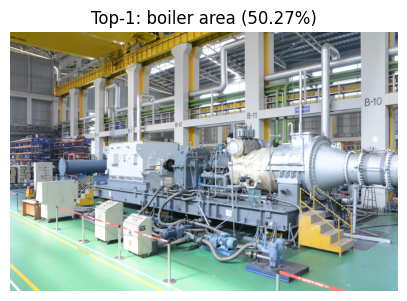

,prompt,probability,plain_label
0,a photo of a boiler area in an industrial ener...,0.502694,boiler area
1,a photo of a turbine in an industrial energy p...,0.238315,turbine
2,a photo of a pump in an industrial energy plant,0.081689,pump
3,a photo of a valve in an industrial energy plant,0.064597,valve
4,a photo of a switchgear in an industrial energ...,0.055370,switchgear


In [ ]:
# 7. Single-image classification demo

# Replace this path with one of your uploaded images, e.g. "turbine_1.jpg"
example_image_path = "/content/sample_data/plant_images/Blog3-1-scaled.jpg"  # <- change this

try:
    img = load_image(example_image_path)
    preds = classify_image_with_clip(img, text_prompts, model, processor, device=device, top_k=5)
    show_image_with_predictions(img, preds)
except FileNotFoundError as e:
    print(e)
    print("Please update `example_image_path` to point to a real file.")

### What just happened?

1. We loaded an **energy plant image** (or a placeholder image if you pointed to another photo).  
2. We sent the image + a list of **text prompts** (plant components) to CLIP.  
3. CLIP computed **similarity scores** and we converted them to probabilities with `softmax`.  
4. We displayed the **top‑k labels** (e.g., *turbine*, *valve*, *control panel*) with their probabilities.

> This is already a **useful Visual AI tool**: you can drag & drop a new plant photo and instantly get a suggested label.


In [ ]:
# 8. Batch scoring for a folder of images

def classify_folder(
    folder_path: str,
    text_prompts: List[str],
    model: CLIPModel,
    processor: CLIPProcessor,
    device: str = "cpu",
    top_k: int = 3,
):
    """Classify all images in a folder and return a DataFrame of results."""
    records = []

    if not os.path.isdir(folder_path):
        raise NotADirectoryError(f"Folder not found: {folder_path}")

    image_files = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp"))
    ]

    for fname in image_files:
        fpath = os.path.join(folder_path, fname)
        img = load_image(fpath)
        preds = classify_image_with_clip(img, text_prompts, model, processor, device=device, top_k=top_k)

        top1 = preds[0]
        records.append({
            "filename": fname,
            "top1_label": top1["plain_label"],
            "top1_prob": top1["probability"],
            "all_predictions": preds,
        })

    df = pd.DataFrame(records)
    return df


# Example usage (update the folder name)
folder = "plant_images"  # e.g. a folder with turbine/valve/etc. photos

if os.path.isdir(folder):
    batch_df = classify_folder(folder, text_prompts, model, processor, device=device, top_k=3)
    display(batch_df[["filename", "top1_label", "top1_prob"]])
else:
    print(f"Folder '{folder}' not found. Create it and add images, or change the path.")

Folder 'plant_images' not found. Create it and add images, or change the path.


## 9. Optional: Add Ground Truth Labels and Measure Accuracy

If you want to turn this into a **proper mini‑project**, you can:

1. Create a CSV file, e.g. `labels.csv`, with columns:
   - `filename` – image file name  
   - `true_label` – the real component type (e.g., `turbine`, `valve`)  

2. After running the batch classification, **join** predictions with this CSV and measure accuracy.


In [ ]:
import os
import pandas as pd

# Folder where your images are stored
folder = "plant_images"   # change if needed

# Get all image filenames from the folder
image_files = [
    f for f in os.listdir(folder)
    if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp"))
]

print(f"Found {len(image_files)} images in '{folder}'")

# OPTION 1: Create an empty template for you to fill manually
labels_df = pd.DataFrame({
    "filename": image_files,
    "true_label": ""   # fill this later (e.g., turbine, valve, control_panel)
})

# OPTION 2 (optional): auto-infer label from filename prefix before underscore
# e.g. turbine_01.jpg -> 'turbine'
# labels_df["true_label"] = labels_df["filename"].str.split("_").str[0]

# Save to CSV
labels_csv = "labels.csv"
labels_df.to_csv(labels_csv, index=False)

print(f"Saved template labels file to {labels_csv}")
display(labels_df.head())


Found 0 images in 'plant_images'
Saved template labels file to labels.csv


,filename,true_label


In [ ]:
# 9.1 Example: join predictions with ground-truth labels and compute accuracy

labels_csv = "labels.csv"  # <-- create this file with filename,true_label

if "batch_df" in globals() and os.path.exists(labels_csv):
    gt = pd.read_csv(labels_csv)
    merged = batch_df.merge(gt, on="filename", how="inner")

    merged["correct"] = merged["top1_label"] == merged["true_label"]
    accuracy = merged["correct"].mean()

    print(f"Number of images with labels: {len(merged)}")
    print(f"Top-1 accuracy: {accuracy:.2%}")

    display(merged[["filename", "true_label", "top1_label", "top1_prob", "correct"]])
else:
    print("Either `batch_df` is not defined yet or `labels.csv` was not found.")

Either `batch_df` is not defined yet or `labels.csv` was not found.


## 10. Connecting Visual AI to MLOps (Optional Extension)

To link this **Visual AI project** with your earlier **MLflow + Evidently** work:

- Treat CLIP inference as a **model** and log:
  - Parameters: model name, prompt set, device, etc.  
  - Metrics: accuracy on labeled images, per‑class accuracy.  
  - Artifacts: a CSV with predictions, confusion matrix images.  

- In a more advanced setup, you could:
  - Integrate **image metadata** (component type, area, timestamp) with **sensor data** (temperature, pressure).  
  - Build a joint dashboard: *"show me all turbine images where pressure was above X."*  

Below is a minimal example of logging a batch evaluation run to MLflow.


In [ ]:
# 10.1 Minimal MLflow logging example for the visual model (optional)

import mlflow

# Configure MLflow (here: local folder; change to remote server if needed)
mlflow.set_tracking_uri("file:///content/mlruns")
mlflow.set_experiment("energy_plant_visual_ai_demo")

if "batch_df" in globals():
    with mlflow.start_run(run_name="clip_visual_inference_batch") as run:
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("num_images", len(batch_df))
        mlflow.log_param("label_set", ", ".join(plain_labels))

        # If we computed accuracy with ground truth above, log it too
        if "accuracy" in globals():
            mlflow.log_metric("top1_accuracy", float(accuracy))

        # Save predictions as CSV
        out_csv = "visual_predictions.csv"
        batch_df.to_json("visual_predictions.json", orient="records", indent=2)
        batch_df.to_csv(out_csv, index=False)
        mlflow.log_artifact(out_csv, artifact_path="predictions")

        print("Logged visual AI batch run with MLflow. Run ID:", run.info.run_id)
else:
    print("Run the batch classification first to create `batch_df`.")

## 11. Project Summary and Workshop Talking Points

You now have a complete **Visual AI mini‑project** for an energy plant context:

- **Concept:** Classify plant components (turbine, valve, control panel, etc.) from images.  
- **Model:** Open‑source **CLIP** model from Hugging Face (`openai/clip-vit-base-patch32`).  
- **Flow:**  
  1. Load & prepare images  
  2. Define prompts that reflect your plant components  
  3. Run zero‑shot inference and inspect predictions  
  4. Batch‑score folders and (optionally) evaluate against labels  
  5. Log results to MLflow for experiment tracking  

### How to present this in your workshop

- Position it as: **“Your first Visual AI pipeline without training a CNN from scratch.”**  
- Emphasize:
  - Re‑using **pre‑trained foundation models**  
  - The importance of **good text prompts**  
  - How this connects with **MLOps** and monitoring over time  

From here, natural next steps are:
- Fine‑tuning a vision model on your own labeled plant dataset  
- Combining image‑based predictions with sensor data for richer risk models  
- Deploying this as a simple web app (e.g., with Gradio or FastAPI) for technicians to upload photos from the field.
